In [2]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import warnings
from os.path import join as oj

import dvu
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import sys
import imodels
from imodels.util.data_util import get_clean_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

from config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from viz import *

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num_datasets 11 9


In [6]:
X, y, feature_names = get_clean_dataset('iai_pecarn.csv', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
m = imodels.SaplingSumClassifier(max_rules=5)

In [8]:
sample_weight = np.ones_like(y_train)
sample_weight[y_train == 1] = 100
m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)

SaplingSumClassifier(max_rules=5)

In [9]:
print(m)

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.764 (leaf)
	GCSScore <= 14.500 (split)
		Val: 0.660 (leaf)
		DecrBreathSound_yes <= 0.500 (split)
			Sex_M <= 0.500 (split)
				Val: 0.000 (leaf)
				Age <= 3.500 (split)
					Val: 0.526 (leaf)
					Val: 0.204 (leaf)
			Val: 0.794 (leaf)



In [10]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
#         stats = sklearn.metrics.classification_report(y_test, preds,
#                                                       output_dict=True,
#                                                       zero_division=0)

#         all_stats['sensitivity'].append(stats['1']['recall'])
#         all_stats['specificity'].append(stats['0']['recall'])
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))


    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-')
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

preds = m.predict_proba(X_test)[:, 1]
# print(sklearn.metrics.classification_report(y_test, preds))

100%|██████████| 6/6 [00:00<00:00, 623.87it/s]


({'sens': [0.9384615384615385,
   0.9230769230769231,
   0.9076923076923077,
   0.8615384615384616,
   0.015384615384615385,
   0.0],
  'spec': [0.19160326852634546,
   0.47393632009016623,
   0.5080304311073541,
   0.5457875457875457,
   0.9935193012116089,
   1.0],
  'ppv': [0.020819112627986348,
   0.031136481577581733,
   0.032686980609418284,
   0.03357314148681055,
   0.041666666666666664,
   nan],
  'npv': [0.9941520467836257,
   0.997036158861885,
   0.9966832504145937,
   0.9953751284686536,
   0.9821727019498607,
   0.9820143884892086],
  'lr+': [1.1608922969675846,
   1.754686663095876,
   1.845017182130584,
   1.896774193548387,
   2.3739130434782663,
   nan],
  'lr-': [0.3211764705882353,
   0.16230677764565982,
   0.18169717138103164,
   0.25369127516778517,
   0.9910380034032898,
   1.0],
  'f1': [0.04073455759599332,
   0.060240963855421686,
   0.06310160427807486,
   0.06462781304096941,
   0.02247191011235955,
   0.0]},
 [0.0,
  0.20442930153321975,
  0.52631578947368

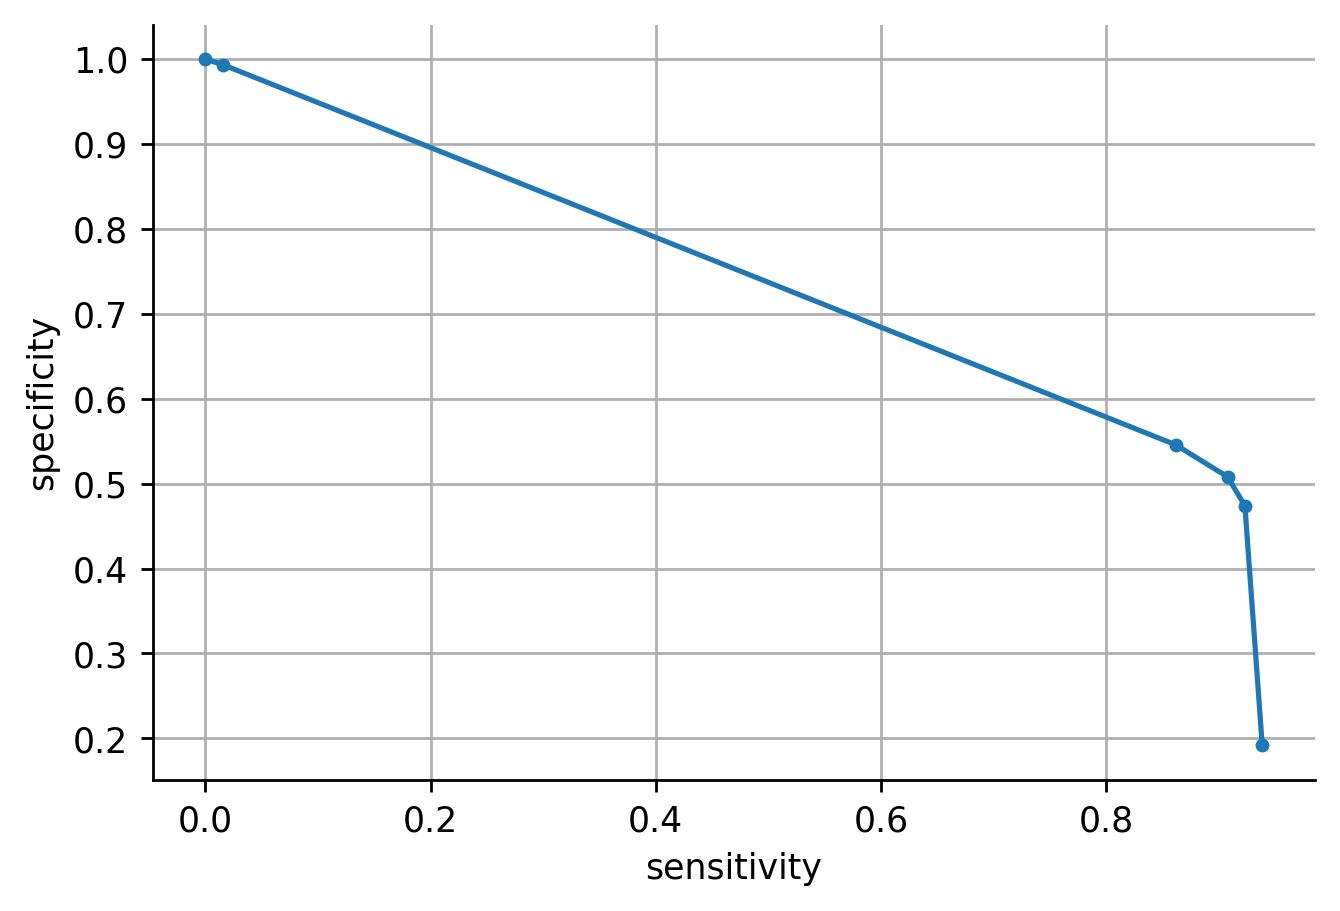

In [11]:
all_stats_curve(y_test, preds, plot=True)